# Chapter 2 - Model Selection and Training
Guilherme de Oliveira <br>
9/11/2016

## Introduction

In Chapter 2 we will work on the classification model of the US Census data that was analyzed in Chapter 1. My biggest interest in modelling will be dealing with the class imbalance of the target variable. In particular, I am interested in the following aspects:
<ul>
<li> How best to assess the accuracy of the classifier. It is unlikely that accuracy will suffice, because of the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox).
<li> What are some approaches that we can use to deal with the class imbalance? Examples include oversampling, undersampling, incorporating clustering algorithms, etc...
</ul>
<br>
<br>
<br>
# This is a work in progress. Stay tuned for more...
<br>
<br>
<br>


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


%matplotlib inline

## Preprocessing Data

In [2]:
# preprocessing function - developped in Chapter 1
the_columns  = [('age', 'continuous'), 
                ('class_of_worker', 'nominal'), 
                ('detailed_industry_code', 'nominal'), 
                ('detailed_occupation_code', 'nominal'), 
                ('education', 'nominal'), 
                ('wage_per_hour', 'continuous'), 
                ('enrolled_in_edu_last_week', 'nominal'),
                ('marital_status', 'nominal'),
                ('major_industry_code', 'nominal'),
                ('major_occupation_code', 'nominal'),
                ('race', 'nominal'),
                ('hispanic_origin', 'nominal'),
                ('sex', 'binary'), # binary column with values Male/Female
                ('member_of_labor_union', 'nominal'), 
                ('reason_for_unemployment', 'nominal'),
                ('full_or_part_time_employment_stat', 'nominal'),
                ('capital_gains', 'continuous'),
                ('capital_losses', 'continuous'),
                ('dividends', 'continuous'),
                ('tax_filer', 'nominal'),
                ('region_of_previous_residence', 'nominal'),
                ('state_of_previous_residence', 'nominal'),
                ('detailed_household_family_stat', 'nominal'),
                ('detailed_household_summary', 'nominal'),
                ('instance_weight', 'IGNORE'), # as per instructions, to be dropped
                ('migration_code_change_in_msa', 'nominal'),
                ('migration_code_change_in_reg', 'nominal'),
                ('migration_code_move_within_reg', 'nominal'),
                ('live_in_this_house_1_yr_ago', 'nominal'),
                ('migration_prev_res_in_sunbelt', 'nominal'),
                ('num_persons_worked_for_employer', 'continuous'),
                ('family_members_under_18', 'nominal'),
                ('cob_father', 'nominal'),
                ('cob_mother', 'nominal'),
                ('cob_self', 'nominal'),
                ('citizenship', 'nominal'),
                ('own_business_or_self_employed', 'nominal'),
                ('fill_in_questionnaire_for_veterans_admin', 'nominal'),
                ('veterans_benefits', 'nominal'),
                ('weeks_worked_in_year', 'nominal'),
                ('year', 'nominal'), 
                ('savings','target')] # binary TARGET variable


In [3]:
def preprocessData(file_name):
    # the_columns stores tuples of (column_name and tag for continuous/nominal/binary/target)
    
    raw_data = pd.read_csv(file_name, names=[c[0] for c in the_columns], index_col=False)
    original_shape = raw_data.shape
    
    raw_data.drop('instance_weight', axis=1, inplace=True)
    the_columns.remove(('instance_weight', 'IGNORE'))
    
    # find the duplicate rows, keep the first one
    duplicate_rows = raw_data.duplicated(keep='first')
    
    print 'number of duplicates = {:d}'.format(duplicate_rows.sum())
    raw_data = raw_data.drop_duplicates(keep='first')
    new_shape =  raw_data.shape
    print 'number of duplicates removed = {:d}'.format(original_shape[0] - new_shape[0])
    print 'original shape = {:d}, {:d}'.format(original_shape[0], original_shape[1])
    print 'new shape = {:d}, {:d}'.format(raw_data.shape[0], raw_data.shape[1])
    
    # convert nominal columns (object dtype) to integer type
    data = pd.DataFrame(raw_data.select_dtypes(include=['object']))
    object_columns = data.columns
    
    for column in object_columns:
        unique_values = data[column].unique()
        dictionary = {key:idx for idx,key in enumerate(unique_values)}
        data[column] = data[column].apply(lambda x : dictionary[x])
    
    # add nominal columns that were already in integer format 
    nominal_integer_columns = [c[0] for c in the_columns 
                               if c[1] == 'nominal' and c[0] not in data.columns]
    data[nominal_integer_columns] = raw_data[nominal_integer_columns]
    
    # convert 'sex', and 'savings' columns to binary; add year column
    data['savings'] = raw_data['savings'].map(lambda x: 
                                              1 if str(x).strip() == '50000+.' else 0)
    data['sex'] = raw_data['sex'].map(lambda x: 
                                      1 if str(x).strip() == 'Male' else 0)
    data['year'] = raw_data['year']
    
    # add continuous columns
    continuous_columns = [c[0] for c in the_columns if c[1] == 'continuous']
    data[continuous_columns] = raw_data[continuous_columns]
    
    # verify that we aren't missing any columns
    assert set(data.columns) == (set(raw_data.columns))
    
    text = 'The final processed data has {:,d} rows and {:d} columns.\n'
    print text.format(data.shape[0], data.shape[1])
    return data


In [4]:
data = preprocessData('us_census_full/census_income_learn.csv')

number of duplicates = 46627
number of duplicates removed = 46627
original shape = 199523, 42
new shape = 152896, 41
The final processed data has 152,896 rows and 41 columns.



In [5]:
data.head(3)

,class_of_worker,education,enrolled_in_edu_last_week,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_labor_union,...,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,age,wage_per_hour,capital_gains,capital_losses,dividends,num_persons_worked_for_employer
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,95,73,0,0,0,0,0
1,1,1,0,1,1,1,0,0,1,0,...,0,2,52,94,58,0,0,0,0,1
2,0,2,1,2,0,0,1,0,0,0,...,0,2,0,95,18,0,0,0,0,0


## One-Hot Encoded Data
This will be required for logistic regression.

In [6]:
def one_hot_encode_nominal_columns(data):
    nominal_columns = [c[0] for c in the_columns if c[1] == 'nominal']
    
    dummy_columns = [pd.get_dummies(data[col], prefix=col, prefix_sep='.') 
                     for col in nominal_columns]
    
    one_hot_encoded_data = pd.concat(dummy_columns, axis=1)
    print '\nThere were {:d} nominal columns to be converted.'.format(len(nominal_columns))
    print 'The number of one-hot-encoded columns is {:d}.\n'.format(data.shape[1])
    
    # check size
    count_distinct_values = 0
    for column in nominal_columns:
        count_distinct_values += len(data[column].unique())
    
    assert count_distinct_values == one_hot_encoded_data.shape[1], \
        "mismatch between number of dummy columns and unique values"
    
    return one_hot_encoded_data

In [7]:
ohe_data = one_hot_encode_nominal_columns(data)

# add target (savings)
ohe_data['savings'] = data['savings']

# scale and add continuous columns
min_max_scaler = MinMaxScaler()
continuous_cols = [c[0] for c in the_columns if c[1] == 'continuous']
ohe_data[continuous_cols] = pd.DataFrame(min_max_scaler.fit_transform(
        data[continuous_cols]), columns=continuous_cols, index = data.index)

print 'The final shape is: {:,d} x {:d}.'.format(ohe_data.shape[0], ohe_data.shape[1])
mx = ohe_data.max().max()
mn = ohe_data.min().min()
print 'To verify scaling: max = {:.2f}, min={:.2f}\n'.format(mx, mn)


There were 33 nominal columns to be converted.
The number of one-hot-encoded columns is 41.

The final shape is: 152,896 x 561.
To verify scaling: max = 1.00, min=0.00



## Functions for Modelling

In [8]:
def get_train_test_data_sets(X, y):
    # obtain training and test set for cross-validation

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    print 'size of training data: {:7d}, {:3d}'.format(X_train.shape[0], X_train.shape[1])
    print 'size of test data:     {:7d}, {:3d}'.format(X_test.shape[0], X_test.shape[1])
    print
    ytr0, ytr1 = (y_train == 0).sum(), (y_train == 1).sum()
    yte0, yte1 = (y_test == 0).sum(), (y_test == 1).sum()
    print 'y_train==0: {:6d},  y_train==1: {:4d},  balance: {:.4f}'.format(
        ytr0, ytr1, float(ytr0)/(ytr0+ytr1))
    print 'y_test==0:  {:6d},  y_test==1:  {:4d},  balance: {:.4f}'.format(
        yte0, yte1, float(yte0)/(yte0+yte1))
    
    return X_train, X_test, y_train, y_test

In [9]:
def print_confusion_matrix(y_true, y_pred):
    header = '\t          prediction 0    prediction 1'
    row0 =   '\tclass 0 {:11,d} {:14,d}'
    row1 =   '\tclass 1 {:11,d} {:14,d}'
    cm = confusion_matrix(y_true, y_pred)
    print header
    print row0.format(cm[0,0], cm[0,1])
    print row1.format(cm[1,0], cm[1,1])
    tp, fn = float(cm[0,0]), float(cm[0,1])
    fp, tn = float(cm[1,0]), float(cm[1,1])
#     print 'precision = {:.4f},  {:.4f}'.format(tp/(tp+fp), tn/(tn+fn))
#     print 'recall =    {:.4f},  {:.4f}'.format(tp/(tp+fn), tn/(tn+fp))


In [10]:
def run_grid_search(classifier, parameters, X_train, y_train, X_test, y_test,
                    score=None, print_grid_scores=False, verbose=0):
    
    clf = GridSearchCV(classifier, parameters, scoring=score, verbose=verbose)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print 'Best parameters on training set:'
    print clf.best_params_
    print '\nBest score = {:.4f}'.format(clf.best_score_)
    if print_grid_scores:
        print '\nGrid scores on training set:\n'
        for params, mean_score, scores in clf.grid_scores_:
            print("%0.4f (+/-%0.04f) for %r"
                  % (mean_score, scores.std() * 2, params))
    print
    print 'Confusion matrix:'
    print_confusion_matrix(y_test, y_pred)
    print '\nClassification report:'
    print classification_report(y_test, y_pred, digits=5)
    return clf

In [11]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    fs=14
    
    for rf in models:
        probs = rf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        label = rf.get_params()['scoring']
        text = ' (area = {:.3f})'.format(roc_auc)
        ax.plot(fpr, tpr, label=label + text)
    
    ax.set_xlabel('False positive rate', fontsize=fs)
    ax.set_ylabel('True positive rate', fontsize=fs)
    ax.set_title('ROC curve', fontsize=fs)
    ax.set_xticks(np.arange(0.0, 1.01, 0.2))
    ax.set_xticklabels(np.arange(0.0,1.01,0.2), fontsize=fs)
    ax.set_yticks(np.arange(0.0, 1.01, 0.2))
    ax.set_yticklabels(np.arange(0.0,1.01,0.2), fontsize=fs)
    ax.set_ylim((0,1.01))
    ax.set_xlim((-0.01, 1.0))
    plt.legend(fontsize=fs, bbox_to_anchor=(1.05,0.5), loc='center left')
    plt.show()

## Random Forest Model
Use scikit-learn modules to run a grid search for a random forest model to find the best parameters. Three cases are run, optimized on different scores: accuracy, precision and recall. Confusion matrices are displayed as well as a classification report.

In [12]:
X = data.drop('savings', axis=1)
y = data.loc[:,'savings']

X_train, X_test, y_train, y_test = get_train_test_data_sets(X, y)


size of training data:  107027,  40
size of test data:       45869,  40

y_train==0:  98399,  y_train==1: 8628,  balance: 0.9194
y_test==0:   42130,  y_test==1:  3739,  balance: 0.9185


In [13]:
parameters = {'n_estimators': [20, 40, 80, 160, 320, 640], 
              'max_depth': [6, None],
              'max_features' : ['sqrt', 40],
              'min_samples_split' : [1, 2]}

#parameters = {'n_estimators': [10], 'max_depth': [6], 'max_features' : ['sqrt'], 'min_samples_split' : [1]}


In [14]:
rf_a = run_grid_search(RandomForestClassifier(), parameters,
                       X_train, y_train, X_test, y_test,
                       score='accuracy', verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 10.3min
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 101.2min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters on training set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 640, 'max_depth': None}

Best score = 0.9408

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,562            568
	class 1       2,184          1,555

Classification report:
             precision    recall  f1-score   support

          0    0.95008   0.98652   0.96795     42130
          1    0.73245   0.41589   0.53054      3739

avg / total    0.93234   0.94000   0.93230     45869



In [15]:
rf_p = run_grid_search(RandomForestClassifier(), parameters,
                       X_train, y_train, X_test, y_test,
                       score='precision', verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 99.9min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters on training set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 160, 'max_depth': 6}

Best score = 0.9078

Confusion matrix:
	          prediction 0    prediction 1
	class 0      42,069             61
	class 1       3,224            515

Classification report:
             precision    recall  f1-score   support

          0    0.92882   0.99855   0.96242     42130
          1    0.89410   0.13774   0.23870      3739

avg / total    0.92599   0.92838   0.90343     45869



In [16]:
rf_r = run_grid_search(RandomForestClassifier(), parameters,
                       X_train, y_train, X_test, y_test,
                       score='recall', verbose=1)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  9.0min
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 99.8min finished


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters on training set:
{'max_features': 40, 'min_samples_split': 1, 'n_estimators': 640, 'max_depth': None}

Best score = 0.4482

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,326            804
	class 1       2,070          1,669

Classification report:
             precision    recall  f1-score   support

          0    0.95230   0.98092   0.96640     42130
          1    0.67489   0.44638   0.53735      3739

avg / total    0.92969   0.93734   0.93142     45869



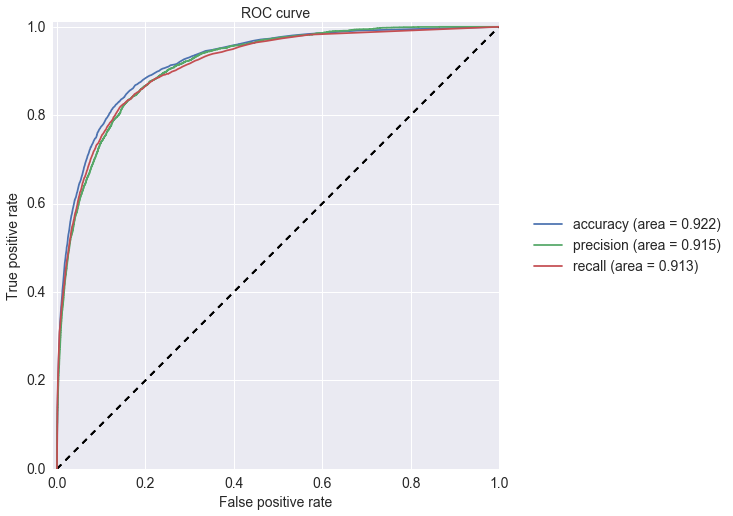

In [17]:
plot_roc_curves([rf_a, rf_p, rf_r], X_test, y_test)

## Logistic Regression
Use one-hot encoded data.

In [18]:
X_ohe = ohe_data.drop('savings', axis=1)
y_ohe = ohe_data.loc[:,'savings']

X_ohe_train, X_ohe_test, y_ohe_train, y_ohe_test = get_train_test_data_sets(X_ohe, y_ohe)


size of training data:  107027, 560
size of test data:       45869, 560

y_train==0:  98399,  y_train==1: 8628,  balance: 0.9194
y_test==0:   42130,  y_test==1:  3739,  balance: 0.9185


In [19]:
parameters = {'penalty': ['l1', 'l2'], 'C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005]}

#parameters = {'penalty': ['l1'], 'C': [0.1]}

In [20]:
lr_a = run_grid_search(LogisticRegression(), parameters, 
                       X_ohe_train, y_ohe_train, X_ohe_test, y_ohe_test,
                       score='accuracy', verbose=1, print_grid_scores=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters on training set:
{'penalty': 'l1', 'C': 0.5}

Best score = 0.9375

Grid scores on training set:

0.9374 (+/-0.0027) for {'penalty': 'l1', 'C': 1.0}
0.9372 (+/-0.0027) for {'penalty': 'l2', 'C': 1.0}
0.9375 (+/-0.0030) for {'penalty': 'l1', 'C': 0.5}
0.9369 (+/-0.0025) for {'penalty': 'l2', 'C': 0.5}
0.9371 (+/-0.0026) for {'penalty': 'l1', 'C': 0.1}
0.9355 (+/-0.0022) for {'penalty': 'l2', 'C': 0.1}
0.9359 (+/-0.0016) for {'penalty': 'l1', 'C': 0.05}
0.9349 (+/-0.0022) for {'penalty': 'l2', 'C': 0.05}
0.9287 (+/-0.0016) for {'penalty': 'l1', 'C': 0.01}
0.9316 (+/-0.0014) for {'penalty': 'l2', 'C': 0.01}
0.9206 (+/-0.0001) for {'penalty': 'l1', 'C': 0.005}
0.9290 (+/-0.0007) for {'penalty': 'l2', 'C': 0.005}

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,584            546
	class 1       2,374          1,365

Classification report:
             precision    recall  f1-score   suppor

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.6min finished


In [21]:
lr_p = run_grid_search(LogisticRegression(), parameters, 
                       X_ohe_train, y_ohe_train, X_ohe_test, y_ohe_test,
                       score='precision', verbose=1, print_grid_scores=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters on training set:
{'penalty': 'l1', 'C': 0.01}

Best score = 0.7717

Grid scores on training set:

0.7125 (+/-0.0253) for {'penalty': 'l1', 'C': 1.0}
0.7124 (+/-0.0237) for {'penalty': 'l2', 'C': 1.0}
0.7165 (+/-0.0277) for {'penalty': 'l1', 'C': 0.5}
0.7131 (+/-0.0241) for {'penalty': 'l2', 'C': 0.5}
0.7334 (+/-0.0302) for {'penalty': 'l1', 'C': 0.1}
0.7147 (+/-0.0258) for {'penalty': 'l2', 'C': 0.1}
0.7386 (+/-0.0227) for {'penalty': 'l1', 'C': 0.05}
0.7198 (+/-0.0310) for {'penalty': 'l2', 'C': 0.05}
0.7717 (+/-0.0410) for {'penalty': 'l1', 'C': 0.01}
0.7339 (+/-0.0280) for {'penalty': 'l2', 'C': 0.01}
0.7654 (+/-0.0995) for {'penalty': 'l1', 'C': 0.005}
0.7454 (+/-0.0101) for {'penalty': 'l2', 'C': 0.005}

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,856            274
	class 1       2,896            843

Classification report:
             precision    recall  f1-score   suppo

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.6min finished


In [22]:
lr_r = run_grid_search(LogisticRegression(),  parameters, 
                       X_ohe_train, y_ohe_train, X_ohe_test, y_ohe_test ,
                       score='recall', verbose=1, print_grid_scores=True)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters on training set:
{'penalty': 'l1', 'C': 1.0}

Best score = 0.3747

Grid scores on training set:

0.3747 (+/-0.0267) for {'penalty': 'l1', 'C': 1.0}
0.3704 (+/-0.0270) for {'penalty': 'l2', 'C': 1.0}
0.3709 (+/-0.0278) for {'penalty': 'l1', 'C': 0.5}
0.3628 (+/-0.0236) for {'penalty': 'l2', 'C': 0.5}
0.3462 (+/-0.0206) for {'penalty': 'l1', 'C': 0.1}
0.3336 (+/-0.0185) for {'penalty': 'l2', 'C': 0.1}
0.3168 (+/-0.0138) for {'penalty': 'l1', 'C': 0.05}
0.3144 (+/-0.0145) for {'penalty': 'l2', 'C': 0.05}
0.1650 (+/-0.0185) for {'penalty': 'l1', 'C': 0.01}
0.2379 (+/-0.0149) for {'penalty': 'l2', 'C': 0.01}
0.0218 (+/-0.0066) for {'penalty': 'l1', 'C': 0.005}
0.1821 (+/-0.0144) for {'penalty': 'l2', 'C': 0.005}

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,574            556
	class 1       2,362          1,377

Classification report:
             precision    recall  f1-score   suppor

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.6min finished


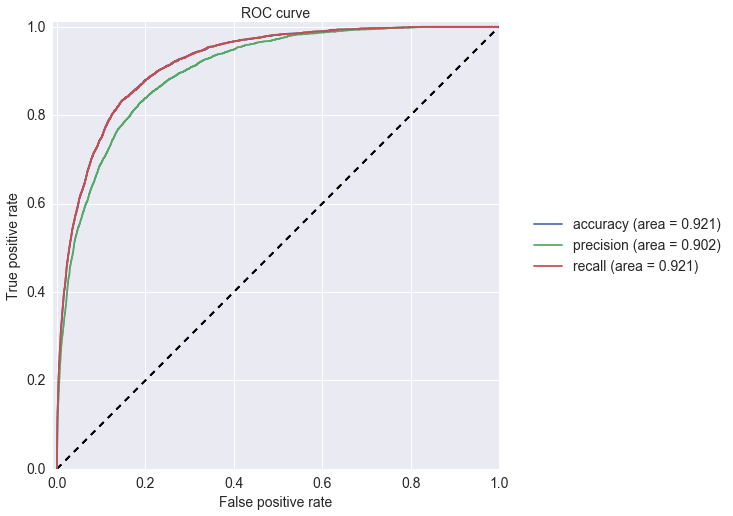

In [23]:
plot_roc_curves([lr_a, lr_p, lr_r], X_ohe_test, y_ohe_test)

## Incorporate Some Feature Engineering
Start with the column "detailed_household_family_stat" and convert the classes that have no savings greater than 50K into one class.

In [24]:
def update_column(column):
    dhfs = data[column][data['savings'] == 1].unique()
    dhfs.sort()
    print 'unique values for svngs = 1', dhfs
    dhfs_all = data[column].unique()
    dhfs_all.sort()
    print 'unique values for all vals ', dhfs_all
    
    diff = set(dhfs_all).difference(set(dhfs))
    print ' the differences are........', diff
    if diff is None:
        print '\n diff is empty'
        return data[column]
    
    print ' len(diff)', len(diff)
    
    val = max(diff) + 1
    print ' mapping values to:', val
    return data[column].map(lambda x : val if x in diff else x)


In [25]:
print data['detailed_household_family_stat'][data['savings']==0].value_counts().shape
data['detailed_household_family_stat'] = update_column('detailed_household_family_stat')
print data['detailed_household_family_stat'][data['savings']==0].value_counts().shape


(38,)
unique values for svngs = 1 [ 0  1  2  3  4  5  6  7 10 11 12 15 16 17 18 19 22 28 30]
unique values for all vals  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
 the differences are........ set([32, 33, 34, 35, 36, 37, 8, 9, 13, 14, 20, 21, 23, 24, 25, 26, 27, 29, 31])
 len(diff) 19
 mapping values to: 38
(20,)


In [26]:
print data['family_members_under_18'][data['savings']==0].value_counts().shape
data['family_members_under_18'] = update_column('family_members_under_18')
print data['family_members_under_18'][data['savings']==0].value_counts().shape


(5,)
unique values for svngs = 1 [0 1]
unique values for all vals  [0 1 2 3 4]
 the differences are........ set([2, 3, 4])
 len(diff) 3
 mapping values to: 5
(3,)


In [27]:
rf_clf = RandomForestClassifier(n_estimators = 40, max_depth=None, max_features=40, min_samples_split=1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print 'confusion matrix:'
print_confusion_matrix(y_test, y_pred)
print '\nDetailed classification report:'
print classification_report(y_test, y_pred, digits=5)

confusion matrix:
	          prediction 0    prediction 1
	class 0      41,315            815
	class 1       2,100          1,639

Detailed classification report:
             precision    recall  f1-score   support

          0    0.95163   0.98066   0.96592     42130
          1    0.66789   0.43835   0.52931      3739

avg / total    0.92850   0.93645   0.93033     45869



## PCA 

In [28]:
# Fit and transform x to visualise inside a 2D feature space

pca = PCA(n_components=2)


In [29]:
def scatter_plot(X, y):
    assert isinstance(y, np.ndarray), "y needs to be numpy.ndarray"
    data_vis = pca.fit_transform(X)
    yeq0 = data_vis[ y==0 ]
    yeq1 = data_vis[ (y==1) ]
    fig=plt.figure(figsize=(9,9));
    ax = fig.gca();
    ax.scatter(yeq0[:, 0], yeq0[:, 1], label="Savings < 50K", alpha=0.7, c='r', edgecolors='face');
    ax.scatter(yeq1[:, 0], yeq1[:, 1], label="Savings > 50K", alpha=0.3, c='b', edgecolors='face');
    ax.legend(fontsize=16, loc='lower left', bbox_to_anchor=(1,0.8));
    return ax

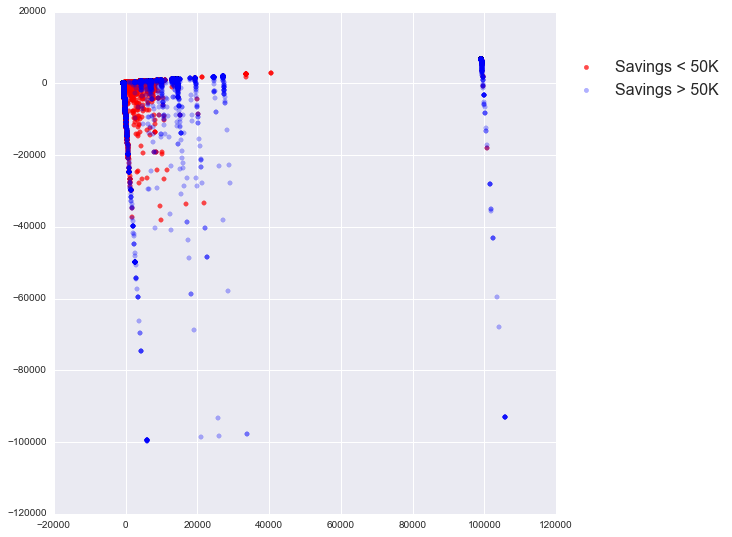

In [30]:
ax = scatter_plot(X, y.as_matrix());

## Class Imbalance: Random Under-Sampling

In [31]:
from imblearn.under_sampling import RandomUnderSampler

In [32]:
# 'Random under-sampling'
US = RandomUnderSampler()
usx, usy = US.fit_sample(X, y)
print 'The new shapes are: {:d}, {:d}'.format(usx.shape[0], usx.shape[1])

n0, n1 = (usy == 0).sum(), (usy == 1).sum()
print 'usy==0: {:6d},  usy==1: {:4d},  balance: {:.4f}'.format(n0, n1, float(n0)/(n0+n1))

The new shapes are: 24734, 40
usy==0:  12367,  usy==1: 12367,  balance: 0.5000


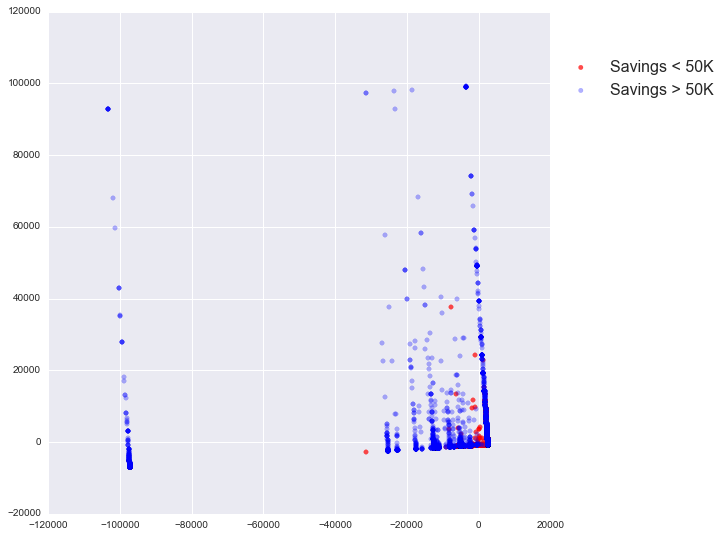

In [33]:
ax = scatter_plot(usx, usy);

In [34]:
usx_train, usx_test, usy_train, usy_test = get_train_test_data_sets(usx, usy)

size of training data:   17313,  40
size of test data:        7421,  40

y_train==0:   8655,  y_train==1: 8658,  balance: 0.4999
y_test==0:    3712,  y_test==1:  3709,  balance: 0.5002


In [51]:
# take best parameters from random forest (accuracy score)
# (need to convert to dictionary of lists)
params = {k:[v] for (k,v) in rf_a.best_params_.iteritems()}
print params

{'max_depth': [None],
 'max_features': ['sqrt'],
 'min_samples_split': [2],
 'n_estimators': [640]}

In [52]:
rfus_r = run_grid_search(RandomForestClassifier(), params,
                       usx_train, usy_train, usx_test, usy_test,
                       score='recall', verbose=1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters on training set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 640, 'max_depth': None}

Best score = 0.8619

Confusion matrix:
	          prediction 0    prediction 1
	class 0       3,171            541
	class 1         517          3,192

Classification report:
             precision    recall  f1-score   support

          0    0.85982   0.85426   0.85703      3712
          1    0.85508   0.86061   0.85783      3709

avg / total    0.85745   0.85743   0.85743      7421



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.7s finished


In [55]:
y_pred = rfus_r.predict(X_test)
    
print 'Confusion matrix:'
print_confusion_matrix(y_test, y_pred)
print '\nClassification report:'
print classification_report(y_test, y_pred, digits=5)

Confusion matrix:
	          prediction 0    prediction 1
	class 0      35,544          6,586
	class 1         175          3,564

Classification report:
             precision    recall  f1-score   support

          0    0.99510   0.84367   0.91315     42130
          1    0.35113   0.95320   0.51321      3739

avg / total    0.94261   0.85260   0.88055     45869



## Class Imbalance: Tomek Links

In [70]:
from imblearn.under_sampling import TomekLinks

In [72]:
TL = TomekLinks()
tlx, tly = TL.fit_sample(X, y)

print 'The new shapes are: {:d}, {:d}'.format(tlx.shape[0], tlx.shape[1])
n0, n1 = (tly == 0).sum(), (tly == 1).sum()
print 'usy==0: {:6d},  usy==1: {:4d},  balance: {:.4f}'.format(n0, n1, float(n0)/(n0+n1))

The new shapes are: 149929, 40
usy==0: 137562,  usy==1: 12367,  balance: 0.9175


In [73]:
tlx_train, tlx_test, tly_train, tly_test = get_train_test_data_sets(tlx, tly)

size of training data:  104950,  40
size of test data:       44979,  40

y_train==0:  96379,  y_train==1: 8571,  balance: 0.9183
y_test==0:   41183,  y_test==1:  3796,  balance: 0.9156


In [74]:
# take best parameters from random forest (accuracy score)
# (need to convert to dictionary of lists)
params = {k:[v] for (k,v) in rf_a.best_params_.iteritems()}
print params

{'max_features': ['sqrt'], 'min_samples_split': [2], 'n_estimators': [640], 'max_depth': [None]}


In [75]:
rftl_r = run_grid_search(RandomForestClassifier(), params,
                         tlx_train, tly_train, tlx_test, tly_test,
                         score='recall', verbose=1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters on training set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 640, 'max_depth': None}

Best score = 0.4579

Confusion matrix:
	          prediction 0    prediction 1
	class 0      40,705            478
	class 1       2,102          1,694

Classification report:
             precision    recall  f1-score   support

          0    0.95090   0.98839   0.96928     41183
          1    0.77993   0.44626   0.56769      3796

avg / total    0.93647   0.94264   0.93539     44979



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min finished


In [76]:
y_pred = rftl_r.predict(X_test)
    
print 'Confusion matrix:'
print_confusion_matrix(y_test, y_pred)
print '\nClassification report:'
print classification_report(y_test, y_pred, digits=5)

Confusion matrix:
	          prediction 0    prediction 1
	class 0      41,800            330
	class 1         634          3,105

Classification report:
             precision    recall  f1-score   support

          0    0.98506   0.99217   0.98860     42130
          1    0.90393   0.83044   0.86563      3739

avg / total    0.97845   0.97898   0.97858     45869



## Class Imbalance: Random Over Sampling

In [57]:
from imblearn.over_sampling import RandomOverSampler

In [60]:
# 'Random over-sampling'
OS = RandomOverSampler(ratio='auto')
osx, osy = OS.fit_sample(X, y)

print 'The new shapes are: {:d}, {:d}'.format(osx.shape[0], osx.shape[1])

n0, n1 = (osy == 0).sum(), (osy == 1).sum()
print 'usy==0: {:6d},  usy==1: {:4d},  balance: {:.4f}'.format(n0, n1, float(n0)/(n0+n1))


The new shapes are: 281058, 40
usy==0: 140529,  usy==1: 140529,  balance: 0.5000


In [66]:
osx_train, osx_test, osy_train, osy_test = get_train_test_data_sets(osx, osy)


size of training data:  196740,  40
size of test data:       84318,  40

y_train==0:  98319,  y_train==1: 98421,  balance: 0.4997
y_test==0:   42210,  y_test==1:  42108,  balance: 0.5006


In [67]:
# take best parameters from random forest (accuracy score)
# (need to convert to dictionary of lists)
params = {k:[v] for (k,v) in rf_a.best_params_.iteritems()}
print params

{'max_features': ['sqrt'], 'min_samples_split': [2], 'n_estimators': [640], 'max_depth': [None]}


In [68]:
rfos_r = run_grid_search(RandomForestClassifier(), params,
                         osx_train, osy_train, osx_test, osy_test,
                         score='recall', verbose=1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters on training set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 640, 'max_depth': None}

Best score = 0.9983

Confusion matrix:
	          prediction 0    prediction 1
	class 0      40,590          1,620
	class 1           0         42,108

Classification report:
             precision    recall  f1-score   support

          0    1.00000   0.96162   0.98043     42210
          1    0.96295   1.00000   0.98113     42108

avg / total    0.98150   0.98079   0.98078     84318



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.5min finished


In [69]:
y_pred = rfos_r.predict(X_test)
    
print 'Confusion matrix:'
print_confusion_matrix(y_test, y_pred)
print '\nClassification report:'
print classification_report(y_test, y_pred, digits=5)

NameError: name 'rfos_r' is not defined